In [2]:
import matplotlib.pyplot as plt
import json

In [3]:
import torch

In [4]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.util import to_pandas
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions

In [5]:
from pts.model.deepar import DeepAREstimator
from pts.dataset.repository.datasets import dataset_recipes
from pts.modules import ZeroInflatedNegativeBinomialOutput

2023-03-06 09:24:40.057162: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 09:24:40.720802: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-06 09:24:40.720872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-06 09:24:40.720879: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [6]:
dataset = get_dataset("pts_m5", regenerate=False)

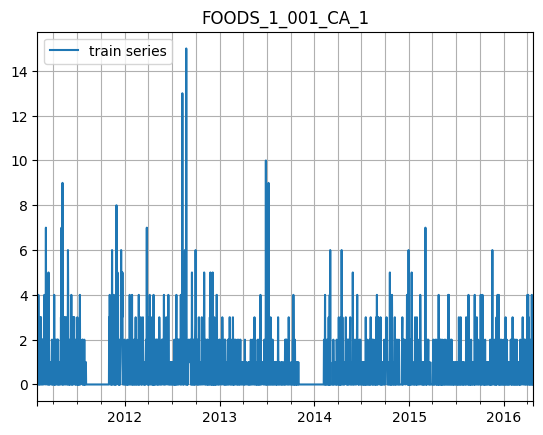

In [7]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

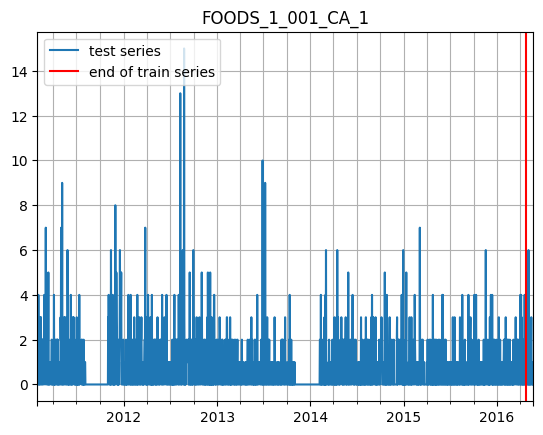

In [8]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.grid(which="both")
plt.legend(["test series", "end of train series"], loc="upper left")
plt.title(entry['item_id'])
plt.show()

In [9]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 28
Frequency of the time series: D


In [14]:
estimator = DeepAREstimator(
    distr_output=ZeroInflatedNegativeBinomialOutput(),
    hidden_size=64,
    num_layers=3,
    dropout_rate=0.1,
    num_feat_dynamic_real=4,
    num_feat_static_cat=5,
    cardinality=[int(cat_feat_info.cardinality) for cat_feat_info in dataset.metadata.feat_static_cat],
    embedding_dimension = [2, 2, 2, 2, 8],
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling="mean",
    trainer_kwargs=dict(max_epochs=25, accelerator='gpu', devices='1'),
)

In [15]:
predictor = estimator.train(dataset.train, cache_data=True, shuffle_buffer_length=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | In sizes | Out sizes   
----------------------------------------------------------------
0 | model | DeepARModel | 122 K  | ?        | [1, 100, 28]
----------------------------------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params
0.491     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 1.46047 (best 1.46047), saving model to '/home/kashif/pytorch-ts/examples/lightning_logs/version_13/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 1.39644 (best 1.39644), saving model to '/home/kashif/pytorch-ts/examples/lightning_logs/version_13/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' was not in top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' was not in top 1
Epoch 5, global step 300: 'train_loss' reached 1.26608 (best 1.26608), saving model to '/home/kashif/pytorch-ts/examples/lightning_logs/version_13/checkpoints/epoch=5-step=300.ckpt' as top 1
Epoch 6, global step 350: 'train_loss' reached 0.95131 (best 0.95131), saving model to '/home/kashif/pytorch-ts/examples/lightning_logs/version_13/checkpoints/epoch=6-step=350.ckpt' as top 1
Epoch 7, global step 400: 'train_loss' reached 0.76792 (best 0.76792),

In [16]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [17]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [18]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))


Running evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████| 30490/30490 [00:00<00:00, 64484.12it/s]
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [19]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4.882023482830875,
    "abs_error": 837647.0,
    "abs_target_sum": 1231764.0,
    "abs_target_mean": 1.4428196598416343,
    "seasonal_error": 1.1272178349378457,
    "MASE": 0.8944776451782529,
    "MAPE": 0.774214062340109,
    "sMAPE": 1.5475747857373254,
    "MSIS": 8.310866456922733,
    "QuantileLoss[0.1]": 238438.80000000005,
    "Coverage[0.1]": 0.0031778569085882955,
    "QuantileLoss[0.2]": 443474.80000000005,
    "Coverage[0.2]": 0.015496884224335847,
    "QuantileLoss[0.3]": 613256.6000000001,
    "Coverage[0.3]": 0.04092325352574614,
    "QuantileLoss[0.4]": 745777.6,
    "Coverage[0.4]": 0.08346530478376984,
    "QuantileLoss[0.5]": 837647.0,
    "Coverage[0.5]": 0.14773227756172985,
    "QuantileLoss[0.6]": 884266.3999999999,
    "Coverage[0.6]": 0.22772337534554657,
    "QuantileLoss[0.7]": 871940.8000000002,
    "Coverage[0.7]": 0.3445473925877337,
    "QuantileLoss[0.8]": 785595.6000000001,
    "Coverage[0.8]": 0.4991941151665652,
    "QuantileLoss[0.9]"

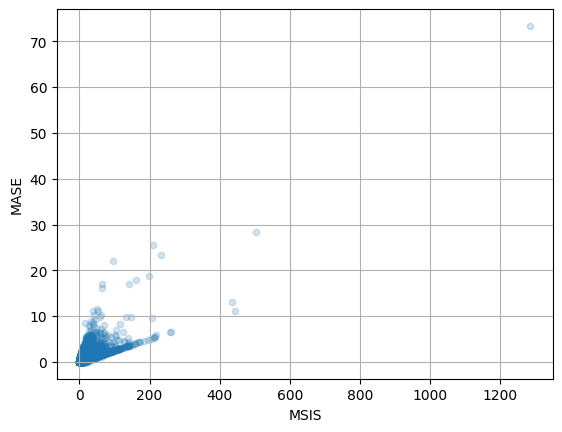

In [21]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter', alpha=0.2)
plt.grid(which="both")
plt.show()